In [66]:
!python -V

Python 3.9.5


In [67]:
import pandas as pd

In [68]:
import pickle

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [71]:
!pwd

/Users/abehsu/mlops-zoomcamp/02-experiment-tracking_hw


In [72]:
import mlflow 

mlflow.set_tracking_uri("sqlite:////tmp/mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2022/05/30 09:25:57 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [73]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [74]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

/Users/abehsu/.local/share/virtualenvs/mlops-zoomcamp-62aZbzDQ/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abehsu/.local/share/virtualenvs/mlops-zoomcamp-62aZbzDQ/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


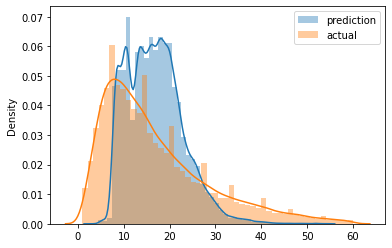

In [75]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [76]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [77]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [78]:
len(df_train), len(df_val)

(73908, 61921)

In [79]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [80]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [81]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [82]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715213828063

In [83]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [84]:
with mlflow.start_run():
    mlflow.set_tag("developer", "abehsu")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(
        local_path="models/lin_reg.bin",
        artifact_path="models_pickle"
        )

In [85]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [86]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [87]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [88]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) - [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[09:26:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:7.37887                           
[1]	validation-rmse:6.75394                           
[2]	validation-rmse:6.70692                           
[3]	validation-rmse:6.69590                           
[4]	validation-rmse:6.68693                           
[5]	validation-rmse:6.67666                           
[6]	validation-rmse:6.66808                           
[7]	validation-rmse:6.66321                           
[8]	validation-rmse:6.66097                           
[9]	validation-rmse:6.66134                           
[10]	validation-rmse:6.65702                          
[11]	validation-rmse:6.65896                          
[12]	validation-rmse:6.65707                          
[13]	validation-rmse:6.65559                          
[14]	validation-rmse:6

2022/05/30 09:26:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5f066de413e549118c2822a1071051c3. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'1000\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' for run ID=\'5f066de413e549118c2822a1071051c3\'.")]')]



[09:26:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.89405                                                    
[1]	validation-rmse:6.77217                                                    
[2]	validation-rmse:6.74935                                                    
[3]	validation-rmse:6.73823                                                    
[4]	validation-rmse:6.71827                                                    
[5]	validation-rmse:6.71272                                                    
[6]	validation-rmse:6.70817                                                    
[7]	validation-rmse:6.70286                                                    
[8]	validation-rmse:6.70199                                                    
[9]	validation-rmse:6.69933                                             

KeyboardInterrupt: 

In [32]:
best_params = {
    'learning_rate': 0.09585355369315604,
    'max_depth': 30,
    'min_child_weight': 1.060597050922164,
    'objective': 'reg:linear',
    'reg_alpha': 0.018060244040060163,
    'reg_lambda': 0.011658731377413597,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params = best_params,
    dtrain = train, 
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)



2022/05/30 01:33:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1d95a764ab3945dd92354579f2123e8b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[01:33:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	vali

2022/05/30 01:35:06 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/05/30 01:35:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/abehsu/.local/share/virtualenvs/mlops-zoomcamp-62aZbzDQ/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [92]:
with mlflow.start_run():
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    # mlflow.log_params(best_params)
    mlflow.xgboost.autolog()

    booster = xgb.train(
        params = best_params,
        dtrain = train, 
        num_boost_round=10,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, "models_mlflow")

    

[09:36:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583


In [93]:
import mlflow
logged_model = 'runs:/2a89fb992e1a4ec0aeaa573a2c6a63a5/models_mlflow'

In [94]:
logged_model

'runs:/2a89fb992e1a4ec0aeaa573a2c6a63a5/models_mlflow'

In [95]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[09:39:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [96]:
xgboost_model

In [97]:
y_pred = xgboost_model.predict(valid)

In [98]:
y_pred[:10]

array([11.090618 ,  4.70716  , 13.853971 , 15.741649 ,  6.238872 ,
       11.085182 ,  9.052172 ,  6.3077555,  5.885979 , 13.089024 ],
      dtype=float32)